In [ ]:
# === Cell 1: Imports and basic settings ===

import numpy as np
import matplotlib.pyplot as plt

# For interactivity (works in Jupyter / Colab)
try:
    from ipywidgets import interact, FloatLogSlider
    HAS_WIDGETS = True
except ImportError:
    HAS_WIDGETS = False

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["font.size"] = 12

In [ ]:
# === Cell 2: Physical constants and model parameters ===

# SI units (you can rescale or non-dimensionalize if you prefer)
G = 6.67430e-11        # m^3 kg^-1 s^-2
c = 2.99792458e8       # m s^-1

# Choose a reference mass (e.g. 10 solar masses)
M_sun = 1.98847e30     # kg
M_ref = 10.0 * M_sun   # kg

# CTC saturation curvature K_max (toy value)
# Physically, this would be set by whatever fundamental scale you choose.
# Here we just pick a large but finite number to illustrate saturation.
K_max = 1e80  # in SI units, purely illustrative!

print(f"Reference mass M_ref = {M_ref:.3e} kg")
print(f"Saturation curvature K_max = {K_max:.3e} (SI units, illustrative)")

Reference mass M_ref = 1.988e+31 kg
Saturation curvature K_max = 1.000e+80 (SI units, illustrative)


In [ ]:
# === Cell 3: Classical Schwarzschild Kretschmann scalar ===

def K_schwarzschild(r, M):
    """
    Classical Schwarzschild Kretschmann scalar:
    K(r) = 48 G^2 M^2 / (c^4 r^6)

    Parameters
    ----------
    r : array_like
        Radius (m). Must be > 0.
    M : float
        Mass (kg).
    """
    r = np.asarray(r)
    return 48 * G**2 * M**2 / (c**4 * r**6)

In [ ]:
# === Cell 4: CTC saturation model ===

def r_s_core(M, K_max=K_max):
    """
    Saturated core radius r_s where K_schwarzschild(r_s, M) = K_max.

    r_s = (48 G^2 M^2 / (c^4 K_max))^(1/6)
    """
    return (48 * G**2 * M**2 / (c**4 * K_max))**(1.0/6.0)

def K_ctc(r, M, K_max=K_max):
    """
    CTC-style saturated curvature profile:

    - For r <= r_s(M): K = K_max (core with finite, constant curvature).
    - For r >  r_s(M): K = K_schwarzschild(r, M).

    Parameters
    ----------
    r : array_like
        Radius (m).
    M : float
        Mass (kg).
    K_max : float
        Saturation curvature.
    """
    r = np.asarray(r)
    rs = r_s_core(M, K_max)
    K_classical = K_schwarzschild(r, M)
    K_out = np.where(r <= rs, K_max, K_classical)
    return K_out, rs

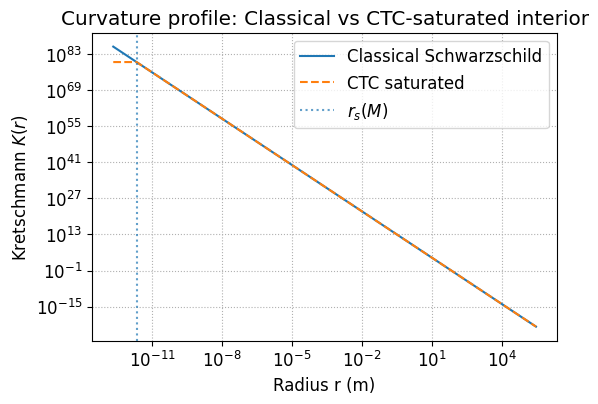

Mass M = 1.988e+31 kg
Schwarzschild radius r_sch = 2.953e+04 m
Saturated core radius r_s   = 2.171e-12 m


In [ ]:
# === Cell 5: Plot K(r) for classical GR vs CTC saturation ===

def plot_curvature_profiles(M=M_ref, K_max=K_max, savefig=False, fname="curvature_profiles.png"):
    # Schwarzschild radius
    rs_gr = 2 * G * M / c**2

    # CTC saturated radius
    rs_ctc = r_s_core(M, K_max)

    # Choose a radial range that covers both GR and CTC core scales
    r_min = min(rs_ctc, rs_gr) * 0.1
    r_max = max(rs_ctc, rs_gr) * 10.0

    r = np.logspace(np.log10(r_min), np.log10(r_max), 500)

    K_gr = K_schwarzschild(r, M)
    K_sat, rs = K_ctc(r, M, K_max)

    plt.figure()
    plt.loglog(r, K_gr, label="Classical Schwarzschild")
    plt.loglog(r, K_sat, linestyle="--", label="CTC saturated")

    # Mark the core radius
    plt.axvline(rs, linestyle=":", label=rf"$r_s(M)$", alpha=0.7)

    plt.xlabel("Radius r (m)")
    plt.ylabel(r"Kretschmann $K(r)$")
    plt.title("Curvature profile: Classical vs CTC-saturated interior")
    plt.legend()
    plt.grid(True, which="both", ls=":")

    if savefig:
        plt.savefig(fname, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"Mass M = {M:.3e} kg")
    print(f"Schwarzschild radius r_sch = {rs_gr:.3e} m")
    print(f"Saturated core radius r_s   = {rs:.3e} m")

# Example static plot
plot_curvature_profiles()

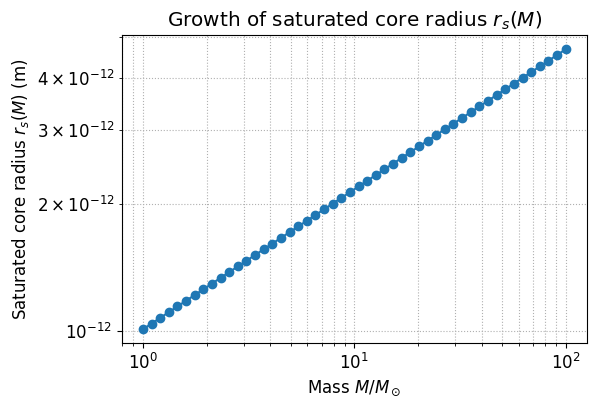

In [ ]:
# === Cell 6: r_s(M) scaling ===

def scan_core_radius(M_min=1.0 * M_sun, M_max=100.0 * M_sun, n_points=50, K_max=K_max, savefig=False, fname="core_radius_scaling.png"):
    M_vals = np.logspace(np.log10(M_min), np.log10(M_max), n_points)
    rs_vals = np.array([r_s_core(M, K_max) for M in M_vals])

    plt.figure()
    plt.loglog(M_vals / M_sun, rs_vals, marker="o")
    plt.xlabel(r"Mass $M / M_\odot$")
    plt.ylabel(r"Saturated core radius $r_s(M)$ (m)")
    plt.title(r"Growth of saturated core radius $r_s(M)$")
    plt.grid(True, which="both", ls=":")

    if savefig:
        plt.savefig(fname, dpi=300, bbox_inches="tight")
    plt.show()

    return M_vals, rs_vals

M_vals, rs_vals = scan_core_radius()

In [ ]:
# === Cell 7: Interactive exploration (if ipywidgets is available) ===

if HAS_WIDGETS:
    slider = FloatLogSlider(
        value=M_ref,
        base=10,
        min=np.log10(1.0 * M_sun) - 1,  # slightly below 1 Msun
        max=np.log10(100.0 * M_sun) + 1,  # above 100 Msun
        step=0.1,
        description='Mass M (kg)',
        continuous_update=False
    )

    @interact(M=slider)
    def interactive_curvature(M):
        plot_curvature_profiles(M=M, K_max=K_max)
else:
    print("ipywidgets not available; skipping interactive slider.")

interactive(children=(FloatLogSlider(value=1.98847e+31, continuous_update=False, description='Mass M (kg)', ma…

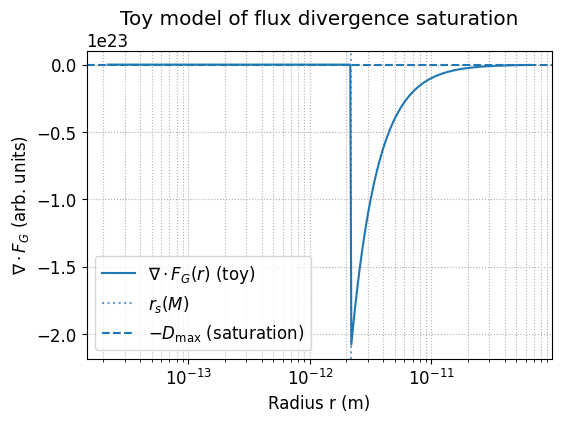

Mass M = 1.988e+31 kg, saturated core radius r_s = 2.171e-12 m


In [ ]:
# === Cell 8: Toy divergence profile for ∇·F_G ===

D_max = 1.0  # arbitrary units, for illustration

def div_FG_toy(r, rs, D_max=D_max):
    """
    Simple toy model:
    - For r > rs: divergence scales like - 1/r^2
    - For r <= rs: saturated at -D_max
    """
    r = np.asarray(r)
    div_free = -1.0 / (r**2 + 1e-30)  # avoid division by zero
    return np.where(r <= rs, -D_max, div_free)

def plot_divergence_profile(M=M_ref, D_max=D_max, savefig=False, fname="divergence_profile.png"):
    rs = r_s_core(M, K_max)

    r_min = rs * 0.01
    r_max = rs * 20.0
    r = np.logspace(np.log10(r_min), np.log10(r_max), 400)

    div_vals = div_FG_toy(r, rs, D_max=D_max)

    plt.figure()
    plt.semilogx(r, div_vals, label=r"$\nabla\cdot F_G(r)$ (toy)")
    plt.axvline(rs, linestyle=":", label=rf"$r_s(M)$", alpha=0.7)
    plt.axhline(-D_max, linestyle="--", label=r"$-D_{\max}$ (saturation)")
    plt.xlabel("Radius r (m)")
    plt.ylabel(r"$\nabla\cdot F_G$ (arb. units)")
    plt.title("Toy model of flux divergence saturation")
    plt.legend()
    plt.grid(True, which="both", ls=":")

    if savefig:
        plt.savefig(fname, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"Mass M = {M:.3e} kg, saturated core radius r_s = {rs:.3e} m")


plot_divergence_profile()